# Label smoothing

This notebook shows our novel method of instance hardness based label smoothing. The instance hardness used in every experiment was produced by an ensemble (of ResNet 'mini', ResNet 'small', ResNet 'large' and 3x CNN 'baseline') --> we consider the IH levels to be fairly accurate.

`**Disclaimer** this notebook is a summary of multiple experiments created to present the explorative process. We omited data loading and preprocessing, etc. For full, functioning notebooks see the 'examples' included.`

## Basic label smoothing | AP100 0.50

In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

# train_generator = DataGenerator(df_train, batch_size=2048, expand_dims_to_rgb=False)

print(f"Using {df_train.shape[0]} training samples.")

Using 315392 training samples.


In [ ]:
'''
Update labels

In this experiment just add label smoothing to all samples.
'''

# Add label smoothing to all labels
df_train.loc[df_train['label'] == 0, 'soft_label'] = 0.05
df_train.loc[df_train['label'] == 1, 'soft_label'] = 0.95


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data = df_train[['miRNA', 'gene', 'soft_label']].progress_apply(lambda row: encode_and_label(row, label_col="soft_label"), axis=1, result_type='expand')

Encoding training data:   0%|          | 0/315392 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_base = create_res_net(name="resnet_small")
  resnet_base.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      # tf.keras.metrics.Precision(name="precision"),
                      # tf.keras.metrics.Recall(name="recall")
                      precision_,
                      recall_
                      ]
      })

resnet_base.summary()

Model: "resnet_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 50, 20, 1)   4           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_93 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_90[0][0]'] 
                                                                                                  
 re_lu_87 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_93[0][0]']   

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_base.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
293/293 [==============================] - 59s 108ms/step - loss: 0.3979 - precision_: 0.0601 - recall_: 0.0944 - val_loss: 0.3427 - val_precision_: 0.2742 - val_recall_: 0.0854
Epoch 2/1000
293/293 [==============================] - 16s 53ms/step - loss: 0.2970 - precision_: 0.4509 - recall_: 0.1795 - val_loss: 0.2874 - val_precision_: 0.5007 - val_recall_: 0.1407
Epoch 3/1000
293/293 [==============================] - 14s 48ms/step - loss: 0.2843 - precision_: 0.6226 - recall_: 0.2812 - val_loss: 0.8341 - val_precision_: 0.2107 - val_recall_: 0.7513
Epoch 4/1000
293/293 [==============================] - 14s 46ms/step - loss: 0.2912 - precision_: 0.5665 - recall_: 0.2600 - val_loss: 0.2955 - val_precision_: 0.4264 - val_recall_: 0.1271
Epoch 5/1000
293/293 [==============================] - 14s 47ms/step - loss: 0.2824 - precision_: 0.6133 - recall_: 0.2664 - val_loss: 0.2867 - val_precision_: 0.4876 - val_recall_: 0.1294
Epoch 6/1000
293/293 [===========================

dict_keys(['loss', 'precision_', 'recall_', 'val_loss', 'val_precision_', 'val_recall_'])


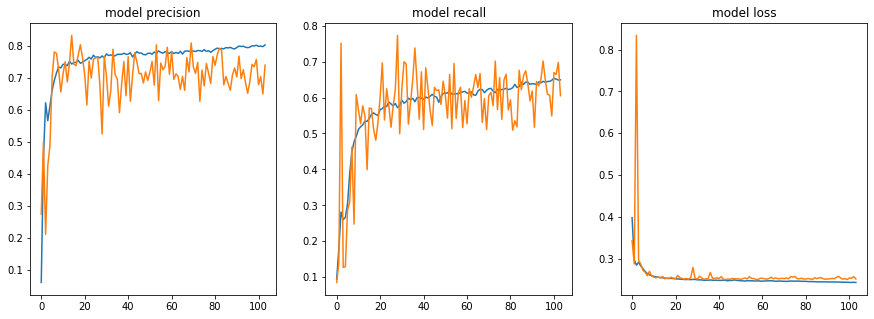

In [ ]:
plot_training(history)

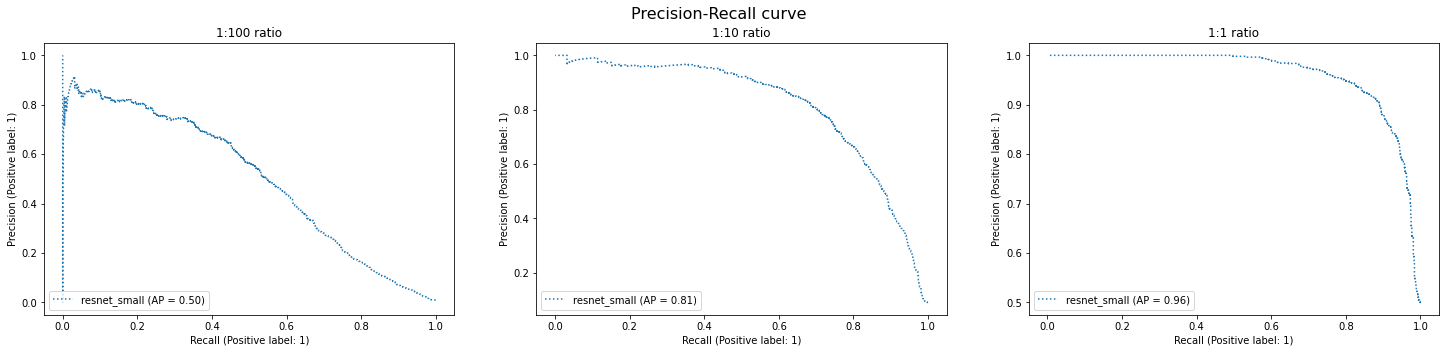

In [ ]:
test_and_plot([resnet_base], test_data_1, test_data_10, test_data_100)

## Instance hardness based label smoothing | AP100 0.53

In [ ]:
# add ih info to the pool

df['ih'] = df_ih
df

,miRNA,gene,label,ih
0,TGTAAACATCCTCGACTGGA,GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAA...,1,0.75
1,TGAGACCTCTGGGTTCTGAG,GACCTCAGAGCTCCAGGATCATCAGTAAATTTGTCATGTTATATAT...,1,0.18
2,GAGGGTTGGGTGGAGGCTCT,TGCCATAATGAACCGTCCAGCCCCTGTGGAGATCTCCTATGAGAAC...,1,0.37
3,CAAAGTGCTTACAGTGCAGG,CACCAGAATTGCCAAAGCACATATATAATAAATTAGATAAAGGGCA...,1,0.64
4,TTAGGGCCCTGGCTCCATCT,AGCCAAGTGGAGAAGGGTTCCTATCCCTGGCAGGTATCTCTGAAAC...,1,0.48
...,...,...,...,...
1554587,CTTGGCACCTAGCAAGCACT,GGGACCCCAGCAGCAACGACATCAACGGGGGCATGGAGCCCACCCC...,0,0.00
1554588,CAGCCCCACAGCCTCAGA,ATGCACAGGCTGACGGACAAGCAGCGGAAGCACCTGAGCATGAAGA...,0,0.00
1554589,CACCCGGCTGTGTGCACATG,CAGTACTTGGTGTACAATGGGGACCTAGTGGAATACGATGCGGACC...,0,0.01
1554590,TTGGCCATGGGGCTGCGCGG,AGATTTCCTGCAACTTCGCCACTTAAAACTCTACCACGAAGGTATC...,0,0.00


In [ ]:
# Prepare undersampled data


df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),

    # Use all hard and positive samples
    df[(df['label'] == 0) & (df['ih'] > 0.1)].sample(frac=1.),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label', 'ih']]
df_train.reset_index(inplace=True)
del df_train['index']

# train_generator = DataGenerator(df_train, batch_size=2048, expand_dims_to_rgb=False)

print(f"Using {df_train.shape[0]} training samples.")

Using 404351 training samples.


In [ ]:
'''
Update labels

In this experiment just add label smoothing to all samples.
'''

# Add label smoothing to all labels
df_train.loc[(df_train['label'] == 0), 'soft_label'] = 0.05
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.3), 'soft_label'] = 0.10
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.5), 'soft_label'] = 0.15
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.7), 'soft_label'] = 0.20

df_train.loc[df_train['label'] == 1, 'soft_label'] = 0.95
# df_train.loc[(df_train['label'] == 1) & (df_train['ih'] >= 0.3), 'soft_label'] = 0.90
# df_train.loc[(df_train['label'] == 1) & (df_train['ih'] >= 0.5), 'soft_label'] = 0.85
# df_train.loc[(df_train['label'] == 1) & (df_train['ih'] >= 0.7), 'soft_label'] = 0.80

In [ ]:
df_train['soft_label'].unique()

array([0.95, 0.05, 0.15, 0.2 , 0.1 ])

In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data = df_train[['miRNA', 'gene', 'soft_label']].progress_apply(lambda row: encode_and_label(row, label_col="soft_label"), axis=1, result_type='expand')

Encoding training data:   0%|          | 0/404351 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_ih_1 = create_res_net(name="resnet_small")
  resnet_ih_1.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      # tf.keras.metrics.Precision(name="precision"),
                      # tf.keras.metrics.Recall(name="recall")
                      precision_,
                      recall_
                      ]
      })

resnet_base.summary()

Model: "resnet_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 50, 20, 1)   4           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_93 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_90[0][0]'] 
                                                                                                  
 re_lu_87 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_93[0][0]']   

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_ih_1.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
376/376 [==============================] - 63s 97ms/step - loss: 0.3441 - precision_: 0.0495 - recall_: 0.0409 - val_loss: 0.4388 - val_precision_: 0.0562 - val_recall_: 0.0130
Epoch 2/1000
376/376 [==============================] - 19s 51ms/step - loss: 0.3065 - precision_: 0.1000 - recall_: 0.0325 - val_loss: 1.3544 - val_precision_: 0.0458 - val_recall_: 0.0216
Epoch 3/1000
376/376 [==============================] - 22s 58ms/step - loss: 0.3008 - precision_: 0.0344 - recall_: 0.0074 - val_loss: 0.3060 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 4/1000
376/376 [==============================] - 19s 51ms/step - loss: 0.2955 - precision_: 0.1007 - recall_: 0.0253 - val_loss: 0.3081 - val_precision_: 0.2454 - val_recall_: 0.1516
Epoch 5/1000
376/376 [==============================] - 20s 54ms/step - loss: 0.2895 - precision_: 0.1456 - recall_: 0.0359 - val_loss: 0.2890 - val_precision_: 0.0125 - val_recall_: 0.0026
Epoch 6/1000
376/376 [====================

dict_keys(['loss', 'precision_', 'recall_', 'val_loss', 'val_precision_', 'val_recall_'])


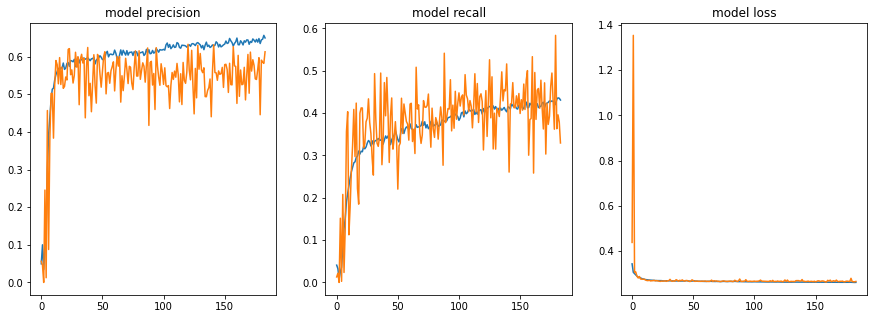

In [ ]:
plot_training(history)

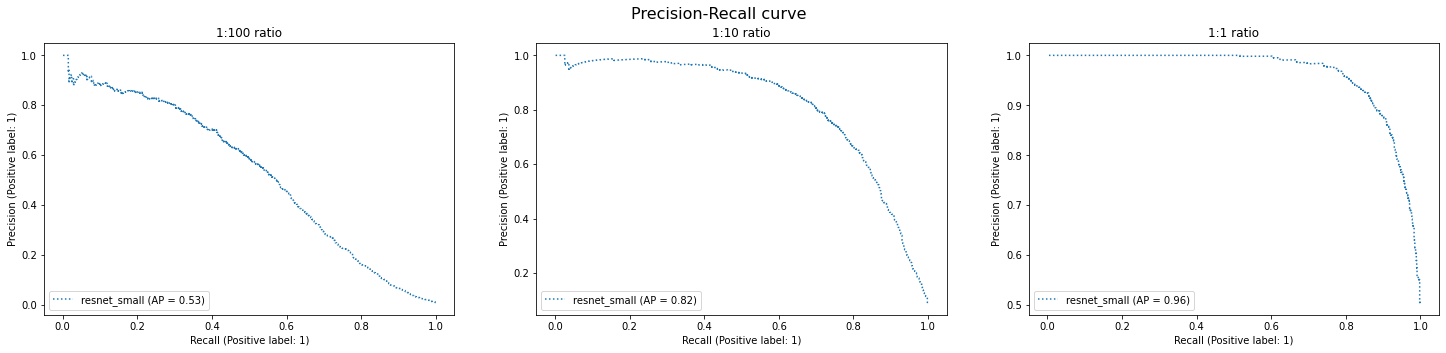

In [ ]:
test_and_plot([resnet_ih_1], test_data_1, test_data_10, test_data_100)

In [ ]:
resnet_ih_1.save("resnet_ih_1.h5")

## Instance hardness based label smoothing | AP100 0.54

This time, soft labels for negative class are smoothed more carefully -> there are 5 smoothing levels.

In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),

    # Use all hard and positive samples
    df[(df['label'] == 0) & (df['ih'] > 0.1)].sample(frac=1.),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label', 'ih']]
df_train.reset_index(inplace=True)
del df_train['index']

# train_generator = DataGenerator(df_train, batch_size=2048, expand_dims_to_rgb=False)

print(f"Using {df_train.shape[0]} training samples.")

Using 404351 training samples.


In [ ]:
'''
Update labels

In this experiment just add label smoothing to all samples.
'''

# Add label smoothing to all labels
df_train.loc[(df_train['label'] == 0), 'soft_label'] = 0.05
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.1), 'soft_label'] = 0.10
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.2), 'soft_label'] = 0.15
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.3), 'soft_label'] = 0.20
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.4), 'soft_label'] = 0.25
df_train.loc[(df_train['label'] == 0) & (df_train['ih'] >= 0.5), 'soft_label'] = 0.30

df_train.loc[df_train['label'] == 1, 'soft_label'] = 0.95

In [ ]:
df_train['soft_label'].value_counts()

0.05    281179
0.10     48355
0.15     22897
0.30     16182
0.95     15392
0.20     12443
0.25      7903
Name: soft_label, dtype: int64

In [ ]:
with strategy.scope():

  resnet_ih_2 = create_res_net(name="resnet_small")
  resnet_ih_2.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      # tf.keras.metrics.Precision(name="precision"),
                      # tf.keras.metrics.Recall(name="recall")
                      precision_,
                      recall_
                      ]
      })

resnet_base.summary()

Model: "resnet_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 50, 20, 1)   4           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_93 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_90[0][0]'] 
                                                                                                  
 re_lu_87 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_93[0][0]']   

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_ih_2.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
376/376 [==============================] - 72s 106ms/step - loss: 0.3894 - precision_: 0.0737 - recall_: 0.0562 - val_loss: 0.4811 - val_precision_: 0.1678 - val_recall_: 0.4028
Epoch 2/1000
376/376 [==============================] - 22s 60ms/step - loss: 0.3437 - precision_: 0.1745 - recall_: 0.0667 - val_loss: 0.3594 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
376/376 [==============================] - 23s 60ms/step - loss: 0.3259 - precision_: 0.3304 - recall_: 0.1509 - val_loss: 0.3250 - val_precision_: 0.3146 - val_recall_: 0.0678
Epoch 4/1000
376/376 [==============================] - 22s 58ms/step - loss: 0.3204 - precision_: 0.4314 - recall_: 0.2149 - val_loss: 0.3142 - val_precision_: 0.4408 - val_recall_: 0.3375
Epoch 5/1000
376/376 [==============================] - 22s 58ms/step - loss: 0.3157 - precision_: 0.4705 - recall_: 0.2643 - val_loss: 0.3122 - val_precision_: 0.4693 - val_recall_: 0.2433
Epoch 6/1000
376/376 [===================

dict_keys(['loss', 'precision_', 'recall_', 'val_loss', 'val_precision_', 'val_recall_'])


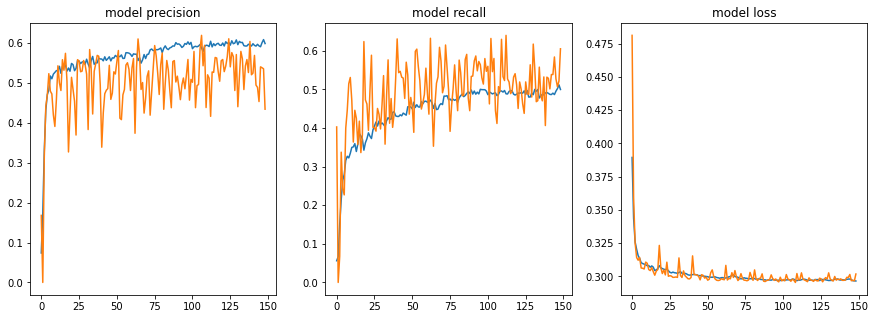

In [ ]:
plot_training(history)

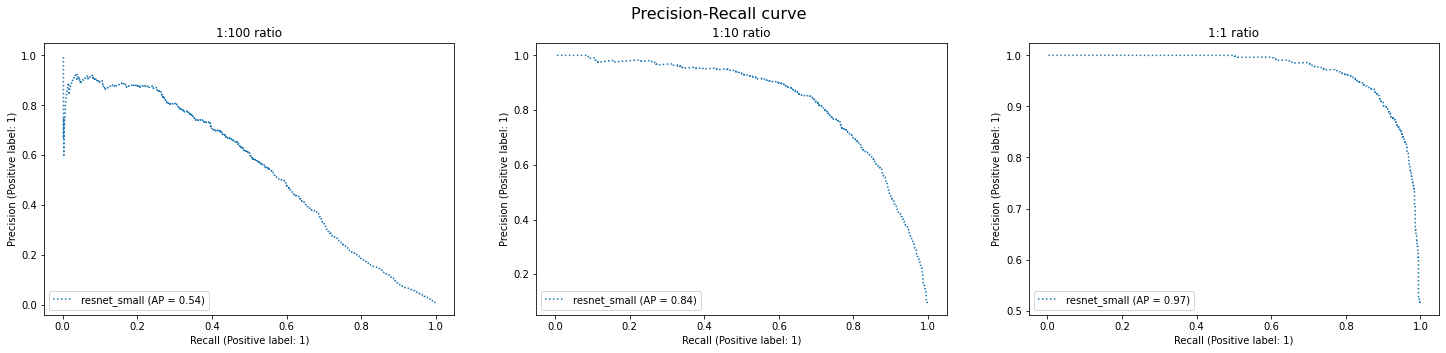

In [ ]:
test_and_plot([resnet_ih_2], test_data_1, test_data_10, test_data_100)

In [ ]:
resnet_ih_2.save("resnet_ih_2.h5")

## Instance hardness based label smoothing **SOFTMAX** | AP100 0.55

This time, soft labels for negative class are smoothed more carefully -> there are 5 smoothing levels.

In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),

    # Use all hard and positive samples
    df[(df['label'] == 0) & (df['ih'] > 0.1)].sample(frac=1.),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label', 'ih']]
df_train.reset_index(inplace=True)
del df_train['index']

# train_generator = DataGenerator(df_train, batch_size=2048, expand_dims_to_rgb=False)

print(f"Using {df_train.shape[0]} training samples.")

Using 404351 training samples.


In [ ]:
def get_soft_labels(df, borders, min_major, increase=0.05, bins=10, defaul_minor=0.95):
  
  # counts, borders = np.histogram(pool['ih'], bins=bins)

  # Set default minor label
  df.loc[df['label'] == 1, ['s_0', 's_1']] = [0.05, 0.95]

  for i in range(1, len(borders)):
    print(borders[i-1:i+1])
    label_change = min_major + (i-1) * increase
    df.loc[(df['label'] == 0) & (df['ih'] >= borders[i-1]),  ['s_0', 's_1']] = [1. - label_change, 0. + label_change]
  
  # Join s_0 and s_1 into a single column
  df['soft_label'] = df.apply(lambda row: [row['s_0'], row['s_1']], axis=1, result_type="reduce")
  
  del df['s_0']
  del df['s_1']

  return df

In [ ]:
borders = np.arange(0.0, 1.1, 0.1)
df_train = get_soft_labels(df_train, borders, 0.05, increase=0.05, defaul_minor=0.95)

[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]


In [ ]:
df_train['soft_label'].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[0.95, 0.05]                                 281179
[0.9, 0.1]                                    48355
[0.85, 0.15000000000000002]                   24445
[0.05, 0.95]                                  15392
[0.8, 0.2]                                    10895
[0.75, 0.25]                                   7903
[0.7, 0.3]                                     6084
[0.6499999999999999, 0.35000000000000003]      3908
[0.6, 0.4]                                     2746
[0.55, 0.45]                                   2331
[0.5, 0.5]                                     1113
Name: soft_label, dtype: int64

In [ ]:
with strategy.scope():

  resnet_small_hist = create_res_net(name="resnet_small_hist", output="softmax")
  resnet_small_hist.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          # "loss": tf.keras.losses.BinaryCrossentropy(),
          "loss": tf.keras.losses.CategoricalCrossentropy(),
          # "metrics": [precision_, recall_]
          "metrics": []
      })

resnet_small_hist.summary()

Model: "resnet_small_hist"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 50, 20, 1)   4           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_62 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_60[0][0]'] 
                                                                                                  
 re_lu_58 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_62[0][0]

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=30, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_small_hist.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
376/376 [==============================] - 52s 79ms/step - loss: 0.3546 - val_loss: 0.3588
Epoch 2/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3294 - val_loss: 0.3287
Epoch 3/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3209 - val_loss: 0.3127
Epoch 4/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3147 - val_loss: 0.3071
Epoch 5/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3102 - val_loss: 0.3060
Epoch 6/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3072 - val_loss: 0.3021
Epoch 7/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3057 - val_loss: 0.3016
Epoch 8/1000
376/376 [==============================] - 14s 38ms/step - loss: 0.3042 - val_loss: 0.3057
Epoch 9/1000
376/376 [==============================] - 15s 40ms/step - loss: 0.3034 - val_loss: 0.3000
Epoch 10/1000
376/376 [==============================] - 15s 39m

(101000,)
(11000,)
(2000,)


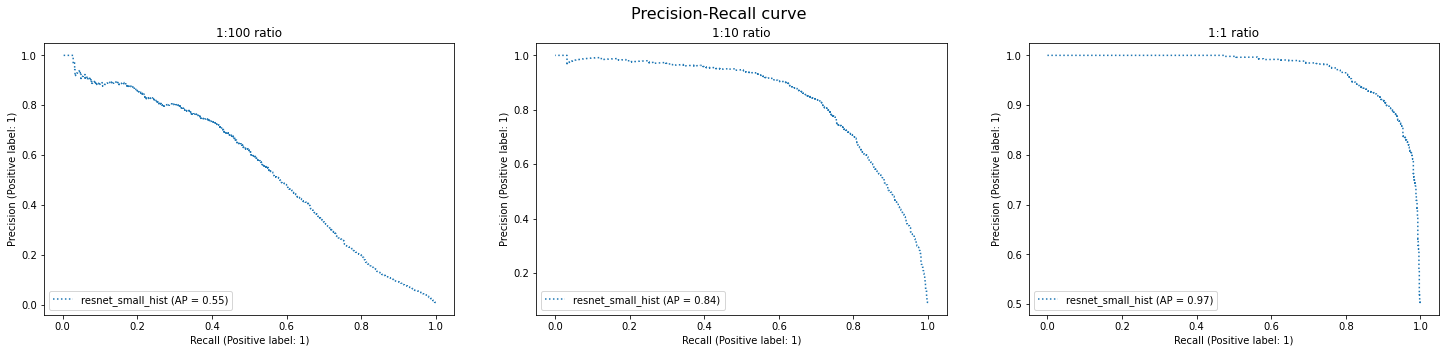

In [ ]:
test_and_plot([resnet_small_hist], test_data_1, test_data_10, test_data_100)